In [84]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torch
import wandb
import os
from Util import *
from tqdm import tqdm
from RBM import *

In [85]:
# N.B. don't apply one-hot encoding on labels - we don't need them (unsupervised learning)
# Applying ToTensor() transform to change type(data) to torch.Tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_transform_1 = torchvision.transforms.ToTensor()
my_transforms = torchvision.transforms.Compose([my_transform_1])

# Set download=True first time to acquire dataset
_MNIST_DATASET = torchvision.datasets.MNIST(root="data/",
                                            download=False,
                                            train=True,
                                            transform=my_transforms)

# Picking out numbers from dataset
numbers = [2]
_MNIST_DATASET.data = _MNIST_DATASET.data[keep_numbers(numbers,_MNIST_DATASET)][:1000]
_MNIST_DATASET.targets = _MNIST_DATASET.targets[keep_numbers(numbers,_MNIST_DATASET)][:1000]
print("nr. datapoints: ",_MNIST_DATASET.data.__len__())

# Transforming to binary
DATA = []
for datapoint in range(_MNIST_DATASET.data.__len__()):
    DATA.append(torch.round((_MNIST_DATASET.data[datapoint]/255)).numpy().flatten().tolist())
DATA = torch.tensor(DATA,device=device)

nr. datapoints:  1000


Initial map: 


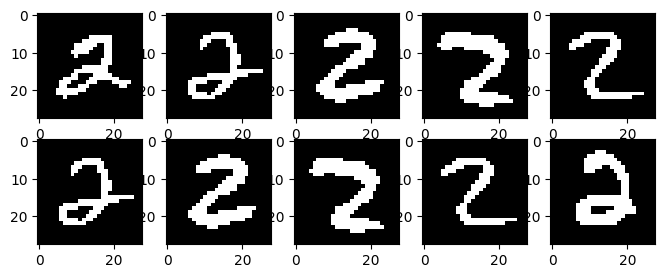

In [86]:
print("Initial map: ")
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols, figsize= (8,3))
for row in range(rows):
    for col in range(cols):
        X_hat = DATA[row+col].reshape((28,28)).detach().numpy()
        ax[row][col].imshow(X_hat, cmap="gray")
plt.show()

In [87]:
_hidden_units = int(DATA[0].shape[0] / 1.5)
_visible_units = DATA[0].shape[0]

my_RBM = RestrictedBoltzmannMachine(hidden_units=_hidden_units,
                                    visible_units=_visible_units)

In [88]:
my_RBM.train_network(dataset=DATA,lr=0.01,epochs=200,batch_size=50,k=20)

Using device:  cpu


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


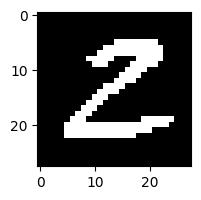

In [89]:
datapoint = DATA[12].reshape((_visible_units,1))
fig, ax = plt.subplots(1,1, figsize= (2,2))
_sample = my_RBM.gibbs_sample(datapoint,steps=1)
ax.imshow(datapoint.reshape((28,28)).detach().numpy(), cmap="gray")
plt.show()


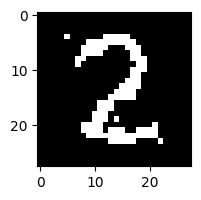

In [92]:
fig, ax = plt.subplots(1,1, figsize= (2,2))
_sample = my_RBM.gibbs_sample(datapoint,steps=100)
ax.imshow(_sample.reshape((28,28)).detach().numpy(), cmap="gray")
plt.show()